In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA
from scipy import sparse
from scipy.sparse import coo_matrix
from scipy.sparse import coo_array
from scipy.sparse import identity

### Recommendations
- coo_array appears only in scipy version 1.8.0

In [2]:
class fock_space:
    def __init__(self, m, N):
        self.m = m
        self.N = N        
        self.j = 0
        
        
        def find_states_number(m,N):
            if (m==0):
                return 1
            else:
                gg = np.ones(N+1)
                hh = np.ones(N+1)
                for j in range(m-1):
                    for i in range(1,N+1):
                        hh[i] = hh[i-1]+gg[i]
                    gg=hh
                return(int(np.sum(gg)))
        
        def warn(n1):
            self.n_k[self.j] = n1
            self.j+=1

        
        def csi(m1, N1, n1, n2, func):
            if (m1==0):
                func(n1)
            else:
                for i in range(N1+1):
                    n2[0]=i
                    n1[m-n2.size:]=n2
                    k=i
                    csi(m1-1, N1-k, n1, n2[1:],func)
        
        K = find_states_number(m,N)
        self.K = K
        
        self.emptyH = coo_matrix((K, K), dtype = complex)
        self.eye = sparse.eye(K)
        
        self.n_k = np.zeros((K,m), dtype = int)
        n = np.ones(m)
        csi(m, N, n, n, warn)
        
        def find_c(p,l,mu):
            fc = 0
            for i in range(p):
                fc += find_states_number(m-l,mu-i)
            return(fc)

        self.c = np.zeros((N+1,m+1,N+1),dtype=int)
        for mu in range(1,N+1):
            for l in range(1,m+1):
                for p in range(1,mu+1):
                    self.c[p,l,mu] = find_c(p,l,mu)
        
        
        self.annihilate=[]
        for k in range(m):
            row = np.zeros(K)
            col = np.arange(K, dtype=int)
            data = np.zeros(K)
            for i in range(K):
                if self.n_k[i,k]==0:
                    row[i] = i 
                else:
                    self.n_k[i,k]-=1
                    p = self.index(self.n_k[i])
                    row[i] = p
                    self.n_k[i,k]+=1
                    data[i]=(self.n_k[i,k])**0.5
            A = coo_matrix((data, (row, col)), shape=(K, K), dtype = complex)
            self.annihilate.append(A) 
            

        self.create=[]
        for k in range(m):
            row = np.zeros(K)
            col = np.arange(K, dtype=int)
            data = np.zeros(K)
            for i in range(K):
                if self.n_k[i,k]==N:
                    row[i] = i 
                else:
                    self.n_k[i,k]+=1
                    p = self.index(self.n_k[i])
                    row[i] = p
                    self.n_k[i,k]-=1
                    data[i]=(self.n_k[i,k]+1)**0.5
            A = coo_matrix((data, (row, col)), shape=(K, K), dtype = complex)
            self.create.append(A) 
        
        
    
    
    
    def occupations(self,i):
        if i >= self.K:
            print('the number is out of range')
        else:
            return(self.n_k[i])

    def index(self,n1):
        def position_of_the_state_do(n1, N1):
            if n1.size == 0:
                return 0
            else:        
                return(self.c[int(n1[0]), self.m-n1.size+1, N1] + position_of_the_state_do(n1[1:],N1-n1[0]))
        if n1.size != self.m:
            print('incorrect size of an array')
        else:
            N1 = self.N
            if(not np.any(n1)):
                return 0
            else:
                return(position_of_the_state_do(n1, N1))

    

class fock_space_kron:
    def __init__(self, f1, f2):
        self.m = f1.m + f2.m
        self.K = f1.K * f2.K
        self.eye = sparse.eye(self.K)
        self.emptyH = coo_matrix((self.K, self.K), dtype = complex)
        
        self.annihilate=[]
        for k in range(f1.m):
            self.annihilate.append(sparse.kron(f1.annihilate[k], f2.eye))
        for k in range(f1.m, self.m):
            self.annihilate.append(sparse.kron(f1.eye, f2.annihilate[k-f1.m]))
        self.create=[]
        for k in range(f1.m):
            self.create.append(sparse.kron(f1.create[k], f2.eye))
        for k in range(f1.m, self.m):
            self.create.append(sparse.kron(f1.eye, f2.create[k-f1.m]))
    
    
    
    def occupations(self,i):
        if i >= self.K:
            print('the number is out of range')
        else:
            n = np.zeros(self.m, dtype = int)
            n[:f1.m] = f1.occupations(i//f2.K)
            n[f1.m:] = f2.occupations(i%f2.K)
            return(n)
        
    def index(self,n1):
        if n1.size != self.m:
            print('incorrect size of an array')
        else:
            return(f1.index(n1[:f1.m]) * f2.K + f2.index(n1[f1.m:]))

In [3]:
def real_time_solver(psi0, dt, tmax, H):
    K = psi0.shape[0]
    Nt = int(tmax/dt)+1
    psi = [psi0, psi0]
    Q = a_dag[0]@a[0]
#    sigmax_average = np.zeros(Nt)
#    sigmax_average[0] = abs(np.conj(psi0)@sigmax@psi0)
#    sigmay_average = np.zeros(Nt)
#    sigmay_average[0] = abs(np.conj(psi0)@sigmay@psi0)
#    sigmaz_average = np.zeros(Nt)
#    sigmaz_average[0] = abs(np.conj(psi0)@sigmaz@psi0)
#    sigma0_average = np.zeros(Nt)
#    sigma0_average[0] = abs(np.conj(psi0)@psi0)
    occupation_of_qubit = np.zeros(Nt)
    occupation_of_qubit[0] = abs(np.conj(psi0)@Q@psi0)
    
    
    for i in range(1,Nt):
        psi_iter_old = psi0
        psi_iter = np.zeros(K)
        psi_compare = psi0
        while (LA.norm(psi_iter-psi_compare)>10**(-6)):
            s = psi[1]+psi_iter_old
            psi_iter = psi[1]+ dt/2*(-1j) * H(i*dt+dt/2)@s
            psi_compare = psi_iter_old
            psi_iter_old = psi_iter
        psi[1] = psi_iter
        occupation_of_qubit[i] = abs(np.conj(psi[1])@Q@psi[1])
#        sigmax_average[i] = abs(np.conj(psi[1])@sigmax@psi[1])
#        sigmay_average[i] = abs(np.conj(psi[1])@sigmay@psi[1])
#        sigmaz_average[i] = abs(np.conj(psi[1])@sigmaz@psi[1])
#        sigma0_average[i] = abs(np.conj(psi[1])@psi[1])
#    return(sigmax_average, sigmay_average, sigmaz_average, sigma0_average )
    return(occupation_of_qubit)

# Usage example

In [5]:
%%time
f1 = fock_space(1,1)
#f2 = fock_space(7,14)
#f = fock_space_kron(f1,f2)


CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
f1.n_k

array([[0],
       [1]])

### Problem parameters

In [5]:
Es = 1
E = 1
h = 0.05

K = f.K
m = f.m
a = f.annihilate
a_dag = f.create

sigmax = a[0] + a_dag[0]
sigmay = 1j*(-a[0] + a_dag[0])
sigmaz = a[0]@a_dag[0] - a_dag[0]@a[0]



psi0 = np.zeros(f.K, dtype = complex)
j1 = 0
psi0[j1]=1



dt = 0.01
tmax = 100

### Hamiltonian building

In [6]:
H0 = f.emptyH
def func(t):
    return(0.1*np.cos(t))


H0 += Es*a_dag[0]@a[0] + h*a_dag[0]@a[1] + h*a[0]@a_dag[1]
for i in range(1,m-1):
    H0 += E * a_dag[i]@a[i] + h * a_dag[i+1]@a[i] + h * a_dag[i]@a[i+1]
    
def H(t):
    return (H0 + sigmax*func(t))


### Evolve the system

In [7]:
%%time
occupation_of_qubit = real_time_solver(psi0, dt, tmax, H)

CPU times: total: 2h 58min 52s
Wall time: 44min 58s


### Visualize the results

C:\Users\mrsgm\AppData\Local\Temp\ipykernel_19220\4280903039.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


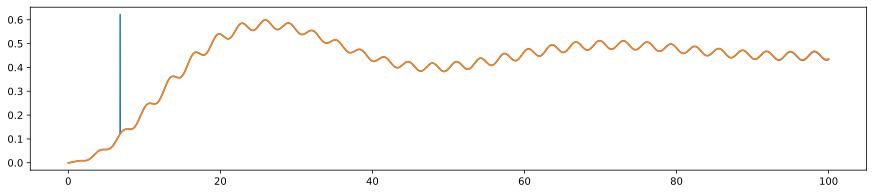

In [14]:
from numpy import loadtxt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

n1 = loadtxt('n.txt')
t=np.linspace(0,tmax,int(tmax/dt)+1)
plt.figure(figsize=(15,3))
#plt.grid()
plt.plot(t, n1)
plt.plot(t, occupation_of_qubit)

#plt.savefig('like_in_article2.svg')


In [39]:
#Then Hamiltonian has constant value
def real_time_solver_const(psi0, dt, tmax, H):
    K = psi0.shape[0]
    Nt = int(tmax/dt)+1
    psi = coo_matrix((Nt,K), dtype = complex)
    psi[0] = psi0
    
    
    for i in range(1,Nt):
        psi_iter_old = psi[0]
        psi_iter = np.zeros(K)
        psi_compare = psi[0]
        while (LA.norm(psi_iter-psi_compare)>10**(-6)):
            s = psi[i-1]+psi_iter_old
            psi_iter = psi[i-1]+ dt/2*(-1j)*H@s
            psi_compare = psi_iter_old
            psi_iter_old = psi_iter
        psi[i] = psi_iter
    return psi
   
    
    

        

In [15]:
f2.K

116280